In [4]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "src"))
import numpy as np
import math
import wandb
from utils import Loss
from dataloader import load_fashion_mnist, load_mnist
from MLP import NeuralNet
from optimizer import GradientDescent
import wandb


2025-03-10 13:58:46.127836: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 13:58:46.158336: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 13:58:46.622742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [63]:
sweep_config = {
    'method': 'bayes',
    'name': 'bayesian_sweep_mse',
}
metric = {
    'name': 'val_accuracy',
    'goal': 'maximize'   
}
sweep_config['metric'] = metric

parameters_dict = {
    "epochs": {'values': [5,10]},
    "num_layers": {'values': [3,4,5]},
    "hidden_size": {'values': [32,64, 128]},
    "weight_decay": {'values': [0, 0.0005, 0.5]},     # [0, 0.0005, 0.5]
    "learning_rate": {'distribution': 'uniform', 'min': 1e-5, 'max': 1e-2},
    "optimizer": {'values':  ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']},    
    "batch_size": {'values': [16, 32, 64]},
    "weight_init" : {'values': ['random', 'xavier']},
    "activation" : {'values': ['ReLU','sigmoid', 'tanh', 'ReLU']},
    "loss" : {'values': ['mse']},
    "momentum" : {'values': [0.9]},
    "beta": {'values': [0.9]},
    "beta1": {'values': [0.9]},
    "beta2": {'values': [0.999]},
    "epsilon": {'values': [1e-8]},
    }

sweep_config['parameters'] = parameters_dict

In [64]:
import pprint
pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'name': 'bayesian_sweep_mse',
 'parameters': {'activation': {'values': ['ReLU', 'sigmoid', 'tanh', 'ReLU']},
                'batch_size': {'values': [16, 32, 64]},
                'beta': {'values': [0.9]},
                'beta1': {'values': [0.9]},
                'beta2': {'values': [0.999]},
                'epochs': {'values': [5, 10]},
                'epsilon': {'values': [1e-08]},
                'hidden_size': {'values': [32, 64, 128]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.01,
                                  'min': 1e-05},
                'loss': {'values': ['mse']},
                'momentum': {'values': [0.9]},
                'num_layers': {'values': [3, 4, 5]},
                'optimizer': {'values': ['sgd',
                                         'momentum',
                                         'nag',
                    

In [65]:
sweep_id = wandb.sweep(sweep_config, project="DL_A1_mse_sweeps")

Create sweep with ID: 9crckhqe
Sweep URL: https://wandb.ai/deeplearn24/DL_A1_mse_sweeps/sweeps/9crckhqe


In [66]:
def train_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        run_name = f"n{config.num_layers}_h{config.hidden_size}_lr{config.learning_rate}_bs{config.batch_size}_act{config.activation}"    
                                                                                                                                 
        wandb.run.name = run_name
        wandb.run.save()
        train, valid, test = load_fashion_mnist(config.batch_size)
        threshold = 1  # Clipping threshold for gradient clipping
        loss = Loss(loss_fn='cross_entropy')
        optimizer = GradientDescent(
            optimizer=config.optimizer,
            lr=config.learning_rate,
            clipping_threshold=threshold,
            momentum=config.momentum,
            beta=config.beta,
            beta1=config.beta1,
            beta2=config.beta2,
            epsilon=config.epsilon,
        )
        model = NeuralNet(
            input_size=784,
            hidden_size=config.hidden_size,
            output_size=10,
            n_hidden=config.num_layers,
            loss=loss,
            activation=[config.activation, "softmax"],
            weight_init=config.weight_init,
            weight_decay=config.weight_decay,
        )

        for epoch in range(config.epochs):
            i = 0
            batch_train_loss = []
            batch_valid_loss = []
            batch_train_accuracy = []
            batch_valid_accuracy = []

            for (x, y) in train:
                loss, accuracy = optimizer.optimize(model, x, y, i)
                batch_train_loss.append(loss)
                batch_train_accuracy.append(accuracy)

                i += 1
                wandb.log({"train/batch_loss": loss})

            for x_val, y_val in valid:
                valid_output, valid_loss, valid_accuracy = model(x_val, y_val)
                batch_valid_loss.append(valid_loss)
                batch_valid_accuracy.append(valid_accuracy)


            wandb.log({"epoch": epoch + 1, "train/loss": np.mean(batch_train_loss), "train/accuracy": np.mean(batch_train_accuracy), "val/loss": np.mean(batch_valid_loss), "val/accuracy": np.mean(batch_valid_accuracy)})
            print(
                f"Epoch: {epoch + 1}, Train Loss: {np.mean(batch_train_loss)}, Valid Loss: {np.mean(batch_valid_loss)}"
            )




wandb: Agent Starting Run: bfpdton7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.00314658979007667
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch: 1, Train Loss: 11826.411636714614, Valid Loss: 17474.486045135403
Epoch: 2, Train Loss: 32671.00808201544, Valid Loss: 57287.078957314625
Epoch: 3, Train Loss: 90023.00201489984, Valid Loss: 124280.71033178583
Epoch: 4, Train Loss: 140777.66215510093, Valid Loss: 160886.54820912878
Epoch: 5, Train Loss: 202287.0864318666, Valid Loss: 242246.37870819384


epoch,▁▃▅▆█
train/accuracy,▂█▄▄▁
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇█
train/loss,▁▂▄▆█
val/accuracy,█▁▄▂▂
val/loss,▁▂▄▅█
epoch,5
train/accuracy,0.10602
train/batch_loss,242176.57186
train/loss,202287.08643
val/accuracy,0.09807


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yuwnzkyu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.006995826985358419
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch: 1, Train Loss: 3.188670155031018, Valid Loss: 2.5946180633118554
Epoch: 2, Train Loss: 2.5780319660525293, Valid Loss: 2.7003257979445
Epoch: 3, Train Loss: 2.576034555925822, Valid Loss: 2.67512958346311
Epoch: 4, Train Loss: 2.581680844655219, Valid Loss: 2.6041509396041405
Epoch: 5, Train Loss: 2.5793140015074414, Valid Loss: 2.4338606809494223


epoch,▁▃▅▆█
train/accuracy,█▃▂▁▁
train/batch_loss,█▆▄█▁▁▆▃▃▁▂▅▃▃▂▃▃▂▃▄▅▅▃▃▄▃▁▅▁▁▄▃▅▄▂▂▂▃▂▇
train/loss,█▁▁▁▁
val/accuracy,█▁▂▂▁
val/loss,▅█▇▅▁
epoch,5
train/accuracy,0.10001
train/batch_loss,2.83353
train/loss,2.57931
val/accuracy,0.0989


wandb: Agent Starting Run: wcx59q03 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.005702912666994084
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 2.7553606041873553, Valid Loss: 2.4361809168309128
Epoch: 2, Train Loss: 2.801139147742899, Valid Loss: 3.887336501369273
Epoch: 3, Train Loss: 2.7823155562063344, Valid Loss: 2.8004985056485467
Epoch: 4, Train Loss: 2.8627959121977247, Valid Loss: 2.6831353154726445
Epoch: 5, Train Loss: 2.872720442279817, Valid Loss: 3.497171030155964
Epoch: 6, Train Loss: 2.841336223892523, Valid Loss: 3.4032239977247665
Epoch: 7, Train Loss: 2.907299281921382, Valid Loss: 2.8881779290915732
Epoch: 8, Train Loss: 2.8574051655099924, Valid Loss: 2.924831951052975
Epoch: 9, Train Loss: 2.9371114482640004, Valid Loss: 3.5089256518032776
Epoch: 10, Train Loss: 2.913508130429122, Valid Loss: 3.0333852496124813


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▇▅█▄▄▆▃▅▁▁
train/batch_loss,▃▅▃▁▆▂▃▁▅▂▅▅▂▃▂▄▃█▂▃▁▅▂▂▁▃▂▇▄▄▂▅▃▄▃▂▂▃▃▄
train/loss,▁▃▂▅▆▄▇▅█▇
val/accuracy,█▁▃▂▂▂▂▂▂▂
val/loss,▁█▃▂▆▆▃▃▆▄
epoch,10
train/accuracy,0.09854
train/batch_loss,4.58969
train/loss,2.91351
val/accuracy,0.10239


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a3qj3385 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0069900012335503536
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 3.934933581726189, Valid Loss: 5.899992369776335
Epoch: 2, Train Loss: 4.103737525786566, Valid Loss: 4.10909876313543
Epoch: 3, Train Loss: 4.081804033067545, Valid Loss: 4.4880660860176125
Epoch: 4, Train Loss: 4.114350376632188, Valid Loss: 4.204123988941827
Epoch: 5, Train Loss: 4.164231295843255, Valid Loss: 3.7160386967492145


epoch,▁▃▅▆█
train/accuracy,█▂▁▂▂
train/batch_loss,▂▁▁▆▆▄▆▅▁▃▃▄▂▅▂▇▂▃▄▄▅▃▂▅▆▃▄▄▃▅▂▅▄▄▂█▃▃▄▅
train/loss,▁▆▅▆█
val/accuracy,▁█▁█▁
val/loss,█▂▃▃▁
epoch,5
train/accuracy,0.1
train/batch_loss,3.82454
train/loss,4.16423
val/accuracy,0.09917


wandb: Agent Starting Run: cxecyi39 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.006456248650165961
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch: 1, Train Loss: 2414.55025539096, Valid Loss: 204.24365621085437
Epoch: 2, Train Loss: 65.46960202093891, Valid Loss: 27.947115500923324
Epoch: 3, Train Loss: 24.87954687077157, Valid Loss: 22.231161888767947
Epoch: 4, Train Loss: 22.072095826448884, Valid Loss: 21.65186173641178
Epoch: 5, Train Loss: 24.20781830708868, Valid Loss: 25.113302010733943
Epoch: 6, Train Loss: 27.77778378227431, Valid Loss: 29.814991568839435
Epoch: 7, Train Loss: 32.80548486688731, Valid Loss: 41.39867365135067
Epoch: 8, Train Loss: 41.32853533339961, Valid Loss: 40.47975682095439
Epoch: 9, Train Loss: 40.40141135837083, Valid Loss: 48.4223517743618
Epoch: 10, Train Loss: 52.762342649888794, Valid Loss: 49.71723176023723


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁███▇▇▇▆▆▆
train/batch_loss,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▂▂▂▃▃▄▄▄▄▄▄▄▄
train/loss,█▁▁▁▁▁▁▁▁▁
val/accuracy,▆██▇▇▇▁▆▄█
val/loss,█▁▁▁▁▁▂▂▂▂
epoch,10
train/accuracy,0.73133
train/batch_loss,50.38468
train/loss,52.76234
val/accuracy,0.81322


wandb: Agent Starting Run: bmtmz2kh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.005003207372509215
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch: 1, Train Loss: 5.314461170298566, Valid Loss: 3.4751393823226904
Epoch: 2, Train Loss: 3.767298555521666, Valid Loss: 3.4354175601527714
Epoch: 3, Train Loss: 3.7598234873968726, Valid Loss: 3.4946177369129927
Epoch: 4, Train Loss: 3.730616190915859, Valid Loss: 4.5358236953023106
Epoch: 5, Train Loss: 3.794385309527284, Valid Loss: 4.805418806134447
Epoch: 6, Train Loss: 3.77701667459468, Valid Loss: 3.202701527693744
Epoch: 7, Train Loss: 3.756099464800059, Valid Loss: 4.134819771221052
Epoch: 8, Train Loss: 3.7854230964300615, Valid Loss: 4.67103818264858
Epoch: 9, Train Loss: 3.7865862667253185, Valid Loss: 3.5903255109296865
Epoch: 10, Train Loss: 3.788771314072052, Valid Loss: 2.719790689400583


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,█▄▇▁▃▄▁▄▁▅
train/batch_loss,█▅▂▄▃▁▂▁▂▂▃▄▄▂▃▃▁▂▃▁▁▂▃▃▁▃▂▂▂▂▃▁▄▁▂▃▄▂▂▃
train/loss,█▁▁▁▁▁▁▁▁▁
val/accuracy,▁▅▇█▄█▇▃▅▅
val/loss,▄▃▄▇█▃▆█▄▁
epoch,10
train/accuracy,0.10063
train/batch_loss,4.26615
train/loss,3.78877
val/accuracy,0.10183


wandb: Agent Starting Run: vq8xpa15 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0061078964689314655
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch: 1, Train Loss: 5.031913407665722, Valid Loss: 2.3073333298068843
Epoch: 2, Train Loss: 2.1652840777939897, Valid Loss: 2.07199234182151
Epoch: 3, Train Loss: 1.6398799048229085, Valid Loss: 1.590759597293915
Epoch: 4, Train Loss: 1.6095371754380334, Valid Loss: 1.9347235786499797
Epoch: 5, Train Loss: 1.8415936448317476, Valid Loss: 2.571434845499222


epoch,▁▃▅▆█
train/accuracy,▁▁██▅
train/batch_loss,█▇▆▆▆▆▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▂▂▂▂▁▁▃▂▂▁
train/loss,█▂▁▁▁
val/accuracy,▁▃█▅▄
val/loss,▆▄▁▃█
epoch,5
train/accuracy,0.31788
train/batch_loss,2.30229
train/loss,1.84159
val/accuracy,0.28075


wandb: Agent Starting Run: a5idjiwg with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0022010664718288605
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch: 1, Train Loss: 13.913497787570348, Valid Loss: 9.609140471895417
Epoch: 2, Train Loss: 9.546919576676478, Valid Loss: 9.52230988090477
Epoch: 3, Train Loss: 9.449822174867325, Valid Loss: 9.38526024415609
Epoch: 4, Train Loss: 9.443234915493425, Valid Loss: 9.34999387680024
Epoch: 5, Train Loss: 9.411927290518713, Valid Loss: 9.32077678991111
Epoch: 6, Train Loss: 9.514445768025347, Valid Loss: 9.33793052181737
Epoch: 7, Train Loss: 9.79815174334692, Valid Loss: 11.01903025090496
Epoch: 8, Train Loss: 9.588360773405032, Valid Loss: 9.30956580760004
Epoch: 9, Train Loss: 9.696764257281222, Valid Loss: 9.259325292814571
Epoch: 10, Train Loss: 9.43359355464278, Valid Loss: 9.234614244849977


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,█▁▂▁▂▂▂▃▃▃
train/batch_loss,█▇▅▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▃▁▁▁▁▁
train/loss,█▁▁▁▁▁▂▁▁▁
val/accuracy,▁▄▆▄▅▇▆▅█▆
val/loss,▂▂▂▁▁▁█▁▁▁
epoch,10
train/accuracy,0.24134
train/batch_loss,9.69675
train/loss,9.43359
val/accuracy,0.24219


wandb: Agent Starting Run: 5680nyh9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.00898774403290618
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch: 1, Train Loss: 43013.84773940166, Valid Loss: 53174.16811764164
Epoch: 2, Train Loss: 63775.519488955346, Valid Loss: 81135.57177636246
Epoch: 3, Train Loss: 90725.5131629823, Valid Loss: 93995.27049249531
Epoch: 4, Train Loss: 117218.45163255207, Valid Loss: 157411.16956253455
Epoch: 5, Train Loss: 226947.93290319017, Valid Loss: 275621.0386726028
Epoch: 6, Train Loss: 344605.7372615195, Valid Loss: 416474.01583296846
Epoch: 7, Train Loss: 484601.1177325409, Valid Loss: 636651.4039868931
Epoch: 8, Train Loss: 923910.3911924036, Valid Loss: 1214660.7338028385
Epoch: 9, Train Loss: 1386335.6040462703, Valid Loss: 1371157.303840976
Epoch: 10, Train Loss: 1277441.7711385489, Valid Loss: 1369612.9240885186


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▅▇█▅▆▅▄▃▄
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▇▇███▇▇▇▇█
train/loss,▁▁▁▁▂▃▃▆█▇
val/accuracy,▃▄█▅▄▂▃▁▁▁
val/loss,▁▁▁▂▂▃▄▇██
epoch,10
train/accuracy,0.34372
train/batch_loss,1368768.60506
train/loss,1277441.77114
val/accuracy,0.33477


wandb: Agent Starting Run: p5wm90gx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.00793978098368686
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 19.792446362739, Valid Loss: 69.23325556061427
Epoch: 2, Train Loss: 179.70930196998506, Valid Loss: 271.34283374023937
Epoch: 3, Train Loss: 308.12415333139916, Valid Loss: 368.739502744685
Epoch: 4, Train Loss: 433.0805497552274, Valid Loss: 513.0016447881054
Epoch: 5, Train Loss: 606.0446513417944, Valid Loss: 770.4565420811842


epoch,▁▃▅▆█
train/accuracy,▇▅▁▅█
train/batch_loss,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇█
train/loss,▁▃▄▆█
val/accuracy,█▁▅▅▅
val/loss,▁▃▄▅█
epoch,5
train/accuracy,0.10228
train/batch_loss,770.56808
train/loss,606.04465
val/accuracy,0.09879


wandb: Agent Starting Run: nd0v31wl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.008359715114031043
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 17187.436486689694, Valid Loss: 27973.771138702246
Epoch: 2, Train Loss: 37009.46570148068, Valid Loss: 74268.02847351071
Epoch: 3, Train Loss: 91128.52767315294, Valid Loss: 113030.84383629535
Epoch: 4, Train Loss: 224674.21730768733, Valid Loss: 328562.18785061745
Epoch: 5, Train Loss: 211921.04148440127, Valid Loss: 146159.18770037233
Epoch: 6, Train Loss: 154878.3516538347, Valid Loss: 238696.74496421788
Epoch: 7, Train Loss: 220952.63671948452, Valid Loss: 140915.0175804898
Epoch: 8, Train Loss: 169362.26376730629, Valid Loss: 225147.21447427289
Epoch: 9, Train Loss: 257108.46198189905, Valid Loss: 207892.22189888902
Epoch: 10, Train Loss: 262410.4557130318, Valid Loss: 319597.1315643241


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▄█▆▄▃▂▂▇▃▁
train/batch_loss,▁▁▁▂▂▂▂▂▂▂▃▄▆█▇▅▅▄▄▄▅▇▅▄▄▄▄▅▅▅▇▇▆▆▅▇▇▇██
train/loss,▁▂▃▇▇▅▇▅██
val/accuracy,▄▆█▁▆▂▆▅▄▁
val/loss,▁▂▃█▄▆▄▆▅█
epoch,10
train/accuracy,0.19756
train/batch_loss,319484.0049
train/loss,262410.45571
val/accuracy,0.16861


wandb: Agent Starting Run: v9a7y1vf with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0013282752161001513
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 0.9736296971714961, Valid Loss: 1.3291007397455343
Epoch: 2, Train Loss: 1.2401011408572369, Valid Loss: 1.648040038339852
Epoch: 3, Train Loss: 1.3310752525944467, Valid Loss: 1.3908237741048595
Epoch: 4, Train Loss: 1.3324886943423422, Valid Loss: 1.8559774963989422
Epoch: 5, Train Loss: 1.3403361131244567, Valid Loss: 1.350749775564842


epoch,▁▃▅▆█
train/accuracy,▁▄▆▇█
train/batch_loss,▅▂▁▃▂▂▅▄▄▄▄▃▆▆▃▂▆▅▃▅▃▄▅▂▅▅▂▂▃▅▄▅▃▇▃█▆▃▇▅
train/loss,▁▆███
val/accuracy,▅▁▂▃█
val/loss,▁▅▂█▁
epoch,5
train/accuracy,0.76862
train/batch_loss,0.39894
train/loss,1.34034
val/accuracy,0.7756


wandb: Agent Starting Run: 3m3vid0s with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.008095328464194878
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 0.9027687122640443, Valid Loss: 0.7547852113319511
Epoch: 2, Train Loss: 1.165782605203626, Valid Loss: 0.9750891638434332
Epoch: 3, Train Loss: 2.2763152660924364, Valid Loss: 7.270240827027357
Epoch: 4, Train Loss: 2.45968497114705, Valid Loss: 1.2309820641019846
Epoch: 5, Train Loss: 1.1376261717592873, Valid Loss: 1.2041587945737213
Epoch: 6, Train Loss: 1.1360090160158864, Valid Loss: 1.232909551805071
Epoch: 7, Train Loss: 1.1652028583002254, Valid Loss: 1.1814876043793252
Epoch: 8, Train Loss: 1.22063804496879, Valid Loss: 1.2263324416679708
Epoch: 9, Train Loss: 1.3148930334257496, Valid Loss: 1.474396334308699
Epoch: 10, Train Loss: 1.3744257394712904, Valid Loss: 1.6324485731530949


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▃▅▁▂████▇▇
train/batch_loss,▂▁▁▂▁▃▃▂▄▅▃▆█▃▄▃▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▄▃▂▂▃
train/loss,▁▂▇█▂▂▂▂▃▃
val/accuracy,█▇▁▇▇███▆▇
val/loss,▁▁█▂▁▂▁▂▂▂
epoch,10
train/accuracy,0.79904
train/batch_loss,1.31804
train/loss,1.37443
val/accuracy,0.77554


wandb: Agent Starting Run: skz4iuqr with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.003028065495480228
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 0.6283829778843776, Valid Loss: 0.5239977527589682
Epoch: 2, Train Loss: 0.491118194263402, Valid Loss: 0.5140774150985056
Epoch: 3, Train Loss: 0.49980321634452846, Valid Loss: 0.4685739012696836
Epoch: 4, Train Loss: 0.5287064135026457, Valid Loss: 0.5215719080157769
Epoch: 5, Train Loss: 0.5750516905293173, Valid Loss: 0.5859148895017702
Epoch: 6, Train Loss: 0.6072635430996145, Valid Loss: 0.6606953917174774
Epoch: 7, Train Loss: 0.6257070675784616, Valid Loss: 0.6680533858521268
Epoch: 8, Train Loss: 0.6098447966877877, Valid Loss: 0.6288794675741489
Epoch: 9, Train Loss: 0.5758211361916149, Valid Loss: 0.6112039452127078
Epoch: 10, Train Loss: 0.5714432764852702, Valid Loss: 0.7138653985724904


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁███▇▆▆▇██
train/batch_loss,▅▃▃▂▂▄▃▁▄▃▁▂▁▂▃▁▂█▂▄▃▄▃▂▄▃▄▄▃▄▁▃▂▂▇▃▅▃▃▄
train/loss,█▁▁▃▅▇█▇▅▅
val/accuracy,▅▇█▇▄▁▃▄▅▄
val/loss,▃▂▁▃▄▆▇▆▅█
epoch,10
train/accuracy,0.83415
train/batch_loss,0.44537
train/loss,0.57144
val/accuracy,0.808


wandb: Agent Starting Run: y3tqjrvw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0039262543946893035
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 0.6041701590427355, Valid Loss: 0.45354002331781956
Epoch: 2, Train Loss: 0.4363931521503173, Valid Loss: 0.4242683145908207
Epoch: 3, Train Loss: 0.4050904761979648, Valid Loss: 0.387461416448873
Epoch: 4, Train Loss: 0.39731693106691013, Valid Loss: 0.467607680937676
Epoch: 5, Train Loss: 0.3943400525775897, Valid Loss: 0.4125152280796859


epoch,▁▃▅▆█
train/accuracy,▁▆▇██
train/batch_loss,▇▇▆▆▅▅▇▅▄▆▃▅▁▃▆▂▁▃▃▄▂▃▁▂▆▃▄▂▃▅▁▄█▁▃▃▁▅▂▂
train/loss,█▂▁▁▁
val/accuracy,▁▅█▁█
val/loss,▇▄▁█▃
epoch,5
train/accuracy,0.86124
train/batch_loss,0.27516
train/loss,0.39434
val/accuracy,0.86508


wandb: Agent Starting Run: cls0bb8c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.005593209490577327
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 98015.55325290236, Valid Loss: 360500.8319937757
Epoch: 2, Train Loss: 992906.0883807932, Valid Loss: 1784122.0291598963
Epoch: 3, Train Loss: 2971002.9232203844, Valid Loss: 4353854.061549508
Epoch: 4, Train Loss: 6059283.723002118, Valid Loss: 7921538.862624391
Epoch: 5, Train Loss: 10230137.527208153, Valid Loss: 12723319.23640339
Epoch: 6, Train Loss: 15623142.089911217, Valid Loss: 18688552.28908677
Epoch: 7, Train Loss: 22174204.261277832, Valid Loss: 25746999.208249543
Epoch: 8, Train Loss: 29547221.073254444, Valid Loss: 33461182.010666393
Epoch: 9, Train Loss: 35474036.910344064, Valid Loss: 36324954.94383903
Epoch: 10, Train Loss: 37201817.66810792, Valid Loss: 38229521.10645821


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▃▁▁▁▁▁▁▁▆█
train/batch_loss,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▆▆▆▆▆▆▆▇▇▇█████
train/loss,▁▁▂▂▃▄▅▇██
val/accuracy,▁▁▂▁▂▁▁▁█▆
val/loss,▁▁▂▂▃▄▆▇██
epoch,10
train/accuracy,0.14731
train/batch_loss,38227718.41247
train/loss,37201817.66811
val/accuracy,0.17683


wandb: Agent Starting Run: xlxndwfr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.00728750879246052
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch: 1, Train Loss: 28634.93089771183, Valid Loss: 49775.89800840439
Epoch: 2, Train Loss: 68717.52727051836, Valid Loss: 81820.62208177155
Epoch: 3, Train Loss: 114031.03894495698, Valid Loss: 179677.01542853107
Epoch: 4, Train Loss: 207873.54940695866, Valid Loss: 252188.65675322304
Epoch: 5, Train Loss: 352965.88952817884, Valid Loss: 437643.3289426021
Epoch: 6, Train Loss: 674878.8815539067, Valid Loss: 986875.2990007265
Epoch: 7, Train Loss: 1506141.6079102124, Valid Loss: 2041056.748527974
Epoch: 8, Train Loss: 2570299.475356915, Valid Loss: 2831137.6935639153
Epoch: 9, Train Loss: 2997403.2028966798, Valid Loss: 3135906.66949381
Epoch: 10, Train Loss: 3708630.102014775, Valid Loss: 3660600.164217728


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▃▆▇▆▂█▂▁▁▂
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▆▆▆▇▇▇▆▆▇█
train/loss,▁▁▁▁▂▂▄▆▇█
val/accuracy,▄▇▅▁█▆▂▁▁▆
val/loss,▁▁▁▁▂▃▅▆▇█
epoch,10
train/accuracy,0.13274
train/batch_loss,3662062.77862
train/loss,3708630.10201
val/accuracy,0.25366


wandb: Agent Starting Run: oacdhlg6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0003799536088199404
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 2.3128400619276044, Valid Loss: 2.317686044173648
Epoch: 2, Train Loss: 2.3096212863172285, Valid Loss: 2.3145078759584123
Epoch: 3, Train Loss: 2.3094643770430237, Valid Loss: 2.3147191311739985
Epoch: 4, Train Loss: 2.3101251386708084, Valid Loss: 2.3204223788624025
Epoch: 5, Train Loss: 2.3102949900807546, Valid Loss: 2.3176501189238192
Epoch: 6, Train Loss: 2.3108776164404348, Valid Loss: 2.3211497541894537
Epoch: 7, Train Loss: 2.290813613245438, Valid Loss: 2.205514163000132
Epoch: 8, Train Loss: 2.27826481342027, Valid Loss: 2.305966626222066
Epoch: 9, Train Loss: 2.311402632473509, Valid Loss: 2.3141111431312837
Epoch: 10, Train Loss: 2.3134841608299705, Valid Loss: 2.3199865039921534


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▁▁▁▁▁▄█▂▁
train/batch_loss,▇▆▂▄▆▃▅▇▆▇▅▆▇▅▆▅▄▆▆▅█▆█▆▅▂▁▇▃▆▇▅▆▅▃▅▆▄▅▃
train/loss,█▇▇▇▇▇▃▁██
val/accuracy,▁▁▁▁▁▁█▂▁▁
val/loss,██████▁▇██
epoch,10
train/accuracy,0.09916
train/batch_loss,2.29642
train/loss,2.31348
val/accuracy,0.1004


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vg0cs30h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0026714913604500568
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch: 1, Train Loss: 101.3318702390537, Valid Loss: 195.45319986105042
Epoch: 2, Train Loss: 263.8783753426319, Valid Loss: 503.14815572162144
Epoch: 3, Train Loss: 946.557269114385, Valid Loss: 1397.9759342611867
Epoch: 4, Train Loss: 2972.667553858181, Valid Loss: 4647.225958134361
Epoch: 5, Train Loss: 5544.474801925471, Valid Loss: 6941.771278586872


epoch,▁▃▅▆█
train/accuracy,▁▆█▄▃
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▅▄▅▆▆▆▇▇▇▇█
train/loss,▁▁▂▅█
val/accuracy,▆▇▁▅█
val/loss,▁▁▂▆█
epoch,5
train/accuracy,0.1283
train/batch_loss,6951.17655
train/loss,5544.4748
val/accuracy,0.158


wandb: Agent Starting Run: gmbzqinx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0015682779487896476
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch: 1, Train Loss: 3.0308360462432837, Valid Loss: 2.360123340701539
Epoch: 2, Train Loss: 2.3751305857879954, Valid Loss: 2.6028100060846797
Epoch: 3, Train Loss: 2.3650204951027156, Valid Loss: 2.353250179693169
Epoch: 4, Train Loss: 2.3030662526426364, Valid Loss: 2.202322772913595
Epoch: 5, Train Loss: 2.2167373782773594, Valid Loss: 2.1941011160806707


epoch,▁▃▅▆█
train/accuracy,▃▁▁▆█
train/batch_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train/loss,█▂▂▂▁
val/accuracy,▁▁▁▅█
val/loss,▄█▄▁▁
epoch,5
train/accuracy,0.15325
train/batch_loss,2.03706
train/loss,2.21674
val/accuracy,0.1506


wandb: Agent Starting Run: qtrb60y9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.00433938743706306
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 2.3079462173724443, Valid Loss: 2.311576096359366
Epoch: 2, Train Loss: 2.309726633036176, Valid Loss: 2.3122130316964054
Epoch: 3, Train Loss: 2.31006335036398, Valid Loss: 2.3116682109167255
Epoch: 4, Train Loss: 2.3075036717266544, Valid Loss: 2.3089964805621177
Epoch: 5, Train Loss: 2.305882920558314, Valid Loss: 2.3088976641376022
Epoch: 6, Train Loss: 2.302645521845696, Valid Loss: 2.288349781900861
Epoch: 7, Train Loss: 2.301481635948591, Valid Loss: 2.307881531069273
Epoch: 8, Train Loss: 2.304520104104014, Valid Loss: 2.3101754269511154
Epoch: 9, Train Loss: 2.304305482386242, Valid Loss: 2.3037144837169397
Epoch: 10, Train Loss: 2.3021995446380883, Valid Loss: 2.305355061662518


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▄▁▁▄▅█▇▅▄▇
train/batch_loss,▅▄▅▃▄▃▅▃▅▆▃▃▄▃▂▃▃▅▂▄▂▅▃▆▅▅▄▅▆█▁▃▁▄▂▃▂▆▆▂
train/loss,▆██▆▅▂▁▃▃▂
val/accuracy,▂▂▁▅▆█▃▃▅▄
val/loss,███▇▇▁▇▇▆▆
epoch,10
train/accuracy,0.10906
train/batch_loss,2.24627
train/loss,2.3022
val/accuracy,0.111


wandb: Agent Starting Run: is0aqqth with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.008504114565812682
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch: 1, Train Loss: 372.9306878978902, Valid Loss: 10.542143150515468
Epoch: 2, Train Loss: 10.688583167052457, Valid Loss: 10.736256076054183
Epoch: 3, Train Loss: 10.622577418851614, Valid Loss: 10.429450760639142
Epoch: 4, Train Loss: 10.64985733208274, Valid Loss: 10.61768692819555
Epoch: 5, Train Loss: 10.744042942016618, Valid Loss: 10.848479787560438
Epoch: 6, Train Loss: 10.767161436518034, Valid Loss: 10.862398697124052
Epoch: 7, Train Loss: 10.835685937627009, Valid Loss: 10.868457340689835
Epoch: 8, Train Loss: 10.925024504216037, Valid Loss: 10.768251895979404
Epoch: 9, Train Loss: 10.924042810439227, Valid Loss: 11.02328244375652
Epoch: 10, Train Loss: 10.971092533498062, Valid Loss: 10.817400611025498


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▆▇▇███▇█
train/batch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▁▁▁▁▁▁▁▁▁
val/accuracy,▃▃▃▅▅▁█▇▅█
val/loss,▂▅▁▃▆▆▆▅█▆
epoch,10
train/accuracy,0.70724
train/batch_loss,10.77784
train/loss,10.97109
val/accuracy,0.74167


wandb: Agent Starting Run: aifu64b5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0038961995342533394
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch: 1, Train Loss: 37.617739855658854, Valid Loss: 90.89543858558324
Epoch: 2, Train Loss: 195.06579452510442, Valid Loss: 301.37455023155957
Epoch: 3, Train Loss: 761.4270687038427, Valid Loss: 1190.0083608297275
Epoch: 4, Train Loss: 1140.3292545711583, Valid Loss: 1227.887754024003
Epoch: 5, Train Loss: 2582.6675410209536, Valid Loss: 3270.361176968694


epoch,▁▃▅▆█
train/accuracy,▅█▁▁▁
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▃▃▄▅▅▅▆▇████
train/loss,▁▁▃▄█
val/accuracy,█▇▁▁▁
val/loss,▁▁▃▄█
epoch,5
train/accuracy,0.10062
train/batch_loss,3270.45424
train/loss,2582.66754
val/accuracy,0.09907


wandb: Agent Starting Run: t343wgy2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0018318819260337768
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 5.715575485993111, Valid Loss: 13.58042420730348
Epoch: 2, Train Loss: 27.66431469845139, Valid Loss: 47.03597690244306
Epoch: 3, Train Loss: 77.99121341115531, Valid Loss: 115.77190514536078
Epoch: 4, Train Loss: 164.9613970596526, Valid Loss: 220.89305054889854
Epoch: 5, Train Loss: 286.0658224099072, Valid Loss: 349.0072802715502
Epoch: 6, Train Loss: 398.02220256113355, Valid Loss: 442.96552296693716
Epoch: 7, Train Loss: 468.56630446558216, Valid Loss: 486.6509214959795
Epoch: 8, Train Loss: 526.3212762889905, Valid Loss: 586.4366426347285
Epoch: 9, Train Loss: 666.9602135576665, Valid Loss: 758.1358611614636
Epoch: 10, Train Loss: 848.9315189251105, Valid Loss: 897.0869227963713


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▁▁▁▂▇▇█▇▄
train/batch_loss,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇██
train/loss,▁▁▂▂▃▄▅▅▆█
val/accuracy,▁▁▁▁▅▅█▆▅▁
val/loss,▁▁▂▃▄▄▅▆▇█
epoch,10
train/accuracy,0.14062
train/batch_loss,897.0542
train/loss,848.93152
val/accuracy,0.10189


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ud8fcola with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0019289551208198257
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch: 1, Train Loss: 5.598939357145272, Valid Loss: 2.350001428910045
Epoch: 2, Train Loss: 2.323084266401351, Valid Loss: 2.3555318050180856
Epoch: 3, Train Loss: 2.322218999094096, Valid Loss: 2.3759050499005303
Epoch: 4, Train Loss: 2.3239035080673367, Valid Loss: 2.3345745131617446
Epoch: 5, Train Loss: 2.323799091354148, Valid Loss: 2.3398021583019846


epoch,▁▃▅▆█
train/accuracy,▂█▁█▆
train/batch_loss,▆▇█▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▁▁▁▁
val/accuracy,▁▁▁▁█
val/loss,▄▅█▁▂
epoch,5
train/accuracy,0.09969
train/batch_loss,2.39944
train/loss,2.3238
val/accuracy,0.10101


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4n97aprx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.00042881598722385847
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch: 1, Train Loss: 34215.36497609132, Valid Loss: 34133.06690889564
Epoch: 2, Train Loss: 34724.22873198691, Valid Loss: 36490.81953142733
Epoch: 3, Train Loss: 41066.85914343927, Valid Loss: 47184.5900617572
Epoch: 4, Train Loss: 55817.304091067876, Valid Loss: 65585.12577140519
Epoch: 5, Train Loss: 76512.3717611035, Valid Loss: 89189.14443473863
Epoch: 6, Train Loss: 104927.29869139774, Valid Loss: 122206.18580063253
Epoch: 7, Train Loss: 142395.77202769977, Valid Loss: 164467.62660236884
Epoch: 8, Train Loss: 189220.44080710463, Valid Loss: 215491.06203400943
Epoch: 9, Train Loss: 242792.4553156873, Valid Loss: 270657.0410738278
Epoch: 10, Train Loss: 299681.7407524509, Valid Loss: 330417.52046626713


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▃▄▃▃▁▆█▆█▇
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
train/loss,▁▁▁▂▂▃▄▅▆█
val/accuracy,▂▅▁▄▄█▇▄▄▄
val/loss,▁▁▁▂▂▃▄▅▇█
epoch,10
train/accuracy,0.14257
train/batch_loss,330390.57444
train/loss,299681.74075
val/accuracy,0.10239


wandb: Agent Starting Run: r19azjbb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.002223839122219557
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch: 1, Train Loss: 9.082325987296931, Valid Loss: 6.11899913061006
Epoch: 2, Train Loss: 5.163630934196217, Valid Loss: 3.9111300772697515
Epoch: 3, Train Loss: 2.93882199504622, Valid Loss: 2.359943507647318
Epoch: 4, Train Loss: 2.141835866341512, Valid Loss: 1.9919229538309033
Epoch: 5, Train Loss: 2.104013499785666, Valid Loss: 2.4008590604044766
Epoch: 6, Train Loss: 2.237235117281461, Valid Loss: 2.3319146775469664
Epoch: 7, Train Loss: 2.2621194759366774, Valid Loss: 1.9611703103975804
Epoch: 8, Train Loss: 2.2173082510024216, Valid Loss: 2.2907634352906956
Epoch: 9, Train Loss: 2.0179728716107554, Valid Loss: 1.7760678423892304
Epoch: 10, Train Loss: 2.0355205540056724, Valid Loss: 1.9681081937876284


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▂▃█▆▃▃▃██
train/batch_loss,██▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▂▁▁▁▁▁▁▁
val/accuracy,▂▂▅█▁▁▅▂▇▇
val/loss,█▄▂▁▂▂▁▂▁▁
epoch,10
train/accuracy,0.21821
train/batch_loss,1.8129
train/loss,2.03552
val/accuracy,0.24091


wandb: Agent Starting Run: 8gukk2bf with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.007665308017895822
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch: 1, Train Loss: 4.76528543614009, Valid Loss: 2.1862644152665474
Epoch: 2, Train Loss: 2.2611701066264667, Valid Loss: 2.258697040554473
Epoch: 3, Train Loss: 2.286326831715235, Valid Loss: 2.2725614693271927
Epoch: 4, Train Loss: 2.2345717560270146, Valid Loss: 2.243929917154923
Epoch: 5, Train Loss: 2.2370342574700213, Valid Loss: 2.2055080174438864
Epoch: 6, Train Loss: 2.2015334038602754, Valid Loss: 2.222574972774937
Epoch: 7, Train Loss: 2.206393739135671, Valid Loss: 2.159628968103084
Epoch: 8, Train Loss: 2.211251859966747, Valid Loss: 2.192415315436593
Epoch: 9, Train Loss: 2.202411221769592, Valid Loss: 2.2170494004063253
Epoch: 10, Train Loss: 2.222731088753997, Valid Loss: 2.2086858811037975


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,█▂▁▁▁▂▂▂▂▂
train/batch_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
train/loss,█▁▁▁▁▁▁▁▁▁
val/accuracy,█▁▃▂▅▄▇▅▄▄
val/loss,▃▇█▆▄▅▁▃▅▄
epoch,10
train/accuracy,0.14602
train/batch_loss,2.33834
train/loss,2.22273
val/accuracy,0.14517


wandb: Agent Starting Run: uzcjyf00 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.003771312938274122
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 1.8724473851009567, Valid Loss: 2.0081524921542018
Epoch: 2, Train Loss: 2.046552522008234, Valid Loss: 4.463568649673431
Epoch: 3, Train Loss: 2.5316672116865195, Valid Loss: 2.466177526083691
Epoch: 4, Train Loss: 3.151961456262464, Valid Loss: 3.1849841569524804
Epoch: 5, Train Loss: 3.5303220104944217, Valid Loss: 3.4253289202307173


epoch,▁▃▅▆█
train/accuracy,▅█▄▅▁
train/batch_loss,▃▃▁▂▄▄▃▄▇▅▂▄▃▃▄▅▃▃▃█▇▃▃▅▄▃▇▄▅▆▄▅▄▅▅▄▅▆▄▄
train/loss,▁▂▄▆█
val/accuracy,█▁▇█▃
val/loss,▁█▂▄▅
epoch,5
train/accuracy,0.61774
train/batch_loss,3.01758
train/loss,3.53032
val/accuracy,0.54967


wandb: Agent Starting Run: n0h4vj45 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0007503556360109088
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch: 1, Train Loss: 6.754211855908489, Valid Loss: 2.830144562640816
Epoch: 2, Train Loss: 2.2086729657133075, Valid Loss: 2.233143577965283
Epoch: 3, Train Loss: 2.0109081074514124, Valid Loss: 1.987063232685215
Epoch: 4, Train Loss: 2.0463326990773845, Valid Loss: 2.1706150294081477
Epoch: 5, Train Loss: 2.1383006192923824, Valid Loss: 2.00371867099532


epoch,▁▃▅▆█
train/accuracy,▁██▇▅
train/batch_loss,█▇▇▃▄▄▄▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
train/loss,█▁▁▁▁
val/accuracy,▃▆▅▁█
val/loss,█▃▁▃▁
epoch,5
train/accuracy,0.21383
train/batch_loss,1.9061
train/loss,2.1383
val/accuracy,0.26762


wandb: Agent Starting Run: 58olhnur with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0058996391186197485
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch: 1, Train Loss: 8381.674984568373, Valid Loss: 289.45607941318946
Epoch: 2, Train Loss: 178.54517364579945, Valid Loss: 166.08690396220635
Epoch: 3, Train Loss: 142.59228427600905, Valid Loss: 173.40376106266692
Epoch: 4, Train Loss: 119.44026292159054, Valid Loss: 150.02137134446394
Epoch: 5, Train Loss: 116.75189983673516, Valid Loss: 115.51218933155101


epoch,▁▃▅▆█
train/accuracy,▂█▆▁▁
train/batch_loss,█▇▆▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▁▁▁▁
val/accuracy,▁██▅▃
val/loss,█▃▃▂▁
epoch,5
train/accuracy,0.5127
train/batch_loss,109.83794
train/loss,116.7519
val/accuracy,0.33145


wandb: Agent Starting Run: 0vf6y02y with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.006124807255058029
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 0.6895778146789114, Valid Loss: 0.5655992764595572
Epoch: 2, Train Loss: 0.7254683433976683, Valid Loss: 0.7379470206126229
Epoch: 3, Train Loss: 0.9017534479864703, Valid Loss: 1.0160212708037257
Epoch: 4, Train Loss: 1.086940549355396, Valid Loss: 1.1983514794725376
Epoch: 5, Train Loss: 1.282992282395574, Valid Loss: 1.435127029688132
Epoch: 6, Train Loss: 1.4255741977737486, Valid Loss: 1.499584255022368
Epoch: 7, Train Loss: 1.5405646064599234, Valid Loss: 1.6012376024149646
Epoch: 8, Train Loss: 1.6844869709591412, Valid Loss: 1.8602737123859776
Epoch: 9, Train Loss: 1.8671848470549788, Valid Loss: 1.955153370556649
Epoch: 10, Train Loss: 1.9902082854462833, Valid Loss: 2.0960527961014006


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▆█▆▄▂▂▃▂▁▁
train/batch_loss,▃▂▃▁▃▂▂▁▄▂▂▂▂▄▆▄▄▄▂▂▃▄▄█▃▃▅▅▃▃▅▅▄▄▄▅▇▅▅▇
train/loss,▁▁▂▃▄▅▆▆▇█
val/accuracy,█▇▅▄▃▁▃▂▅▃
val/loss,▁▂▃▄▅▅▆▇▇█
epoch,10
train/accuracy,0.73491
train/batch_loss,1.704
train/loss,1.99021
val/accuracy,0.73467


wandb: Agent Starting Run: upeq2zfw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.00387711540305354
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch: 1, Train Loss: 23.612659162684974, Valid Loss: 22.3348774544547
Epoch: 2, Train Loss: 21.11068639133642, Valid Loss: 19.876008880770794
Epoch: 3, Train Loss: 19.1190201577078, Valid Loss: 18.68041693129325
Epoch: 4, Train Loss: 18.466339130403806, Valid Loss: 18.09759343300382
Epoch: 5, Train Loss: 18.334220588835887, Valid Loss: 18.13244904727083
Epoch: 6, Train Loss: 18.72397862657526, Valid Loss: 18.953352054019994
Epoch: 7, Train Loss: 18.846232119220325, Valid Loss: 18.88017752530819
Epoch: 8, Train Loss: 18.810511861314463, Valid Loss: 18.5685870627941
Epoch: 9, Train Loss: 18.794655478792585, Valid Loss: 18.819173810921686
Epoch: 10, Train Loss: 18.994945935413043, Valid Loss: 19.19911744362022


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,█▄▁▁▁▁▁▁▁▁
train/batch_loss,▇▃▇█▇▅▄▅▃▃▁▂▂▁▁▁▂▂▁▁▂▁▂▂▁▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂
train/loss,█▅▂▁▁▂▂▂▂▂
val/accuracy,█▂▂▃▂▃▂▃▁▁
val/loss,█▄▂▁▁▂▂▂▂▃
epoch,10
train/accuracy,0.32153
train/batch_loss,19.48827
train/loss,18.99495
val/accuracy,0.2884


wandb: Agent Starting Run: 64fcucqa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.002311230237110687
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch: 1, Train Loss: 11480.556810456479, Valid Loss: 19318.577466657567
Epoch: 2, Train Loss: 34384.42237368967, Valid Loss: 51529.673333611856
Epoch: 3, Train Loss: 55854.53074660339, Valid Loss: 63158.85184080057
Epoch: 4, Train Loss: 82844.7628832302, Valid Loss: 106778.59973857825
Epoch: 5, Train Loss: 136310.94501035186, Valid Loss: 148654.08567231096


epoch,▁▃▅▆█
train/accuracy,█▁▃▄▄
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▆▆▇▇█
train/loss,▁▂▃▅█
val/accuracy,█▁▁▁▁
val/loss,▁▃▃▆█
epoch,5
train/accuracy,0.1016
train/batch_loss,148705.07811
train/loss,136310.94501
val/accuracy,0.10805


wandb: Agent Starting Run: b3ghtk9n with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.009776984941936457
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch: 1, Train Loss: 6413.526086875554, Valid Loss: 289.7232503586092
Epoch: 2, Train Loss: 191.91181586293715, Valid Loss: 159.31850961152114
Epoch: 3, Train Loss: 130.5977167286003, Valid Loss: 129.1800400281447
Epoch: 4, Train Loss: 101.61840598890761, Valid Loss: 92.35720346860197
Epoch: 5, Train Loss: 90.66154033274323, Valid Loss: 151.31997535446723
Epoch: 6, Train Loss: 93.06462073293362, Valid Loss: 89.5819165778951
Epoch: 7, Train Loss: 71.15634623582325, Valid Loss: 88.7439877737206
Epoch: 8, Train Loss: 80.68827799455148, Valid Loss: 87.61972223334956
Epoch: 9, Train Loss: 72.9696720907508, Valid Loss: 133.61499519362744
Epoch: 10, Train Loss: 102.00912777897831, Valid Loss: 122.51573633128497


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,█▅▄▄▁▃▂▅▅▅
train/batch_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▁▁▁▁▁▁▁▁▁
val/accuracy,▁█▆▂▅▁▃▂█▅
val/loss,█▃▂▁▃▁▁▁▃▂
epoch,10
train/accuracy,0.39694
train/batch_loss,121.90123
train/loss,102.00913
val/accuracy,0.35738


wandb: Agent Starting Run: rnvzk2xn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.006366668183737998
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch: 1, Train Loss: 28.651715208523928, Valid Loss: 49.96606940366535
Epoch: 2, Train Loss: 57.66865483264285, Valid Loss: 76.7869287743988
Epoch: 3, Train Loss: 78.18633844921656, Valid Loss: 113.90685496062662
Epoch: 4, Train Loss: 166.18753912261374, Valid Loss: 279.1024398808397
Epoch: 5, Train Loss: 348.0685277370336, Valid Loss: 324.70052679122153
Epoch: 6, Train Loss: 438.07771420748924, Valid Loss: 536.4185459666855
Epoch: 7, Train Loss: 601.7963409650913, Valid Loss: 684.8821784203217
Epoch: 8, Train Loss: 628.1943904262338, Valid Loss: 668.0132200840814
Epoch: 9, Train Loss: 653.1811456969659, Valid Loss: 580.9381853944374
Epoch: 10, Train Loss: 815.6763195450752, Valid Loss: 1200.3322470303249


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▄▆▆█▇▁██▄▅
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▄▄▃▃▃▃▃▄▄▅▅▅▆▆▆▆▅▆▆▆▅▅▆▆█
train/loss,▁▁▁▂▄▅▆▆▇█
val/accuracy,█▃▁▁▁▃▅▁▁▁
val/loss,▁▁▁▂▃▄▅▅▄█
epoch,10
train/accuracy,0.15901
train/batch_loss,1199.58519
train/loss,815.67632
val/accuracy,0.10389


wandb: Agent Starting Run: 2qevftan with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.005485248720814948
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 45.9575626476279, Valid Loss: 126.78336489839822
Epoch: 2, Train Loss: 156.84225262941047, Valid Loss: 176.05560372085606
Epoch: 3, Train Loss: 160.43362003698485, Valid Loss: 193.27590469287165
Epoch: 4, Train Loss: 264.02513575965094, Valid Loss: 345.6088072121369
Epoch: 5, Train Loss: 375.68280900860736, Valid Loss: 462.92485947225003
Epoch: 6, Train Loss: 566.9731339042435, Valid Loss: 730.8995015426879
Epoch: 7, Train Loss: 946.8018984722495, Valid Loss: 1171.478341690702
Epoch: 8, Train Loss: 1194.4593749482883, Valid Loss: 1223.6697444209906
Epoch: 9, Train Loss: 1357.164746806186, Valid Loss: 1763.316016755774
Epoch: 10, Train Loss: 2085.1706717710913, Valid Loss: 2518.2577428258596


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▁▆█▁▂▅█▂▁
train/batch_loss,▁▁▁▁▁▁▂▂▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆███
train/loss,▁▁▁▂▂▃▄▅▆█
val/accuracy,▂▁▇▁▁▁█▂▂▁
val/loss,▁▁▁▂▂▃▄▄▆█
epoch,10
train/accuracy,0.09829
train/batch_loss,2516.20041
train/loss,2085.17067
val/accuracy,0.09802


wandb: Agent Starting Run: bzdi8yjk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.002489491314536489
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch: 1, Train Loss: 11.78435968696948, Valid Loss: 11.22167123349915
Epoch: 2, Train Loss: 9.038150812052832, Valid Loss: 5.892662454634643
Epoch: 3, Train Loss: 4.042533400251971, Valid Loss: 3.0722648857574586
Epoch: 4, Train Loss: 2.172948766866958, Valid Loss: 2.0305207262766833
Epoch: 5, Train Loss: 2.1684096698901847, Valid Loss: 1.877336664139697


epoch,▁▃▅▆█
train/accuracy,▁▁▃█▆
train/batch_loss,▇▇▇█▆█▇▆▆▇▆▇▆▆▅▄▆▅▄▅▂▂▂▂▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁
train/loss,█▆▂▁▁
val/accuracy,▁▁▅▆█
val/loss,█▄▂▁▁
epoch,5
train/accuracy,0.24101
train/batch_loss,1.96752
train/loss,2.16841
val/accuracy,0.36303


wandb: Agent Starting Run: ozvjbdd4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0011151865676019854
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 3.604226032134877, Valid Loss: 6.893714300560235
Epoch: 2, Train Loss: 53.12906460285051, Valid Loss: 199.7931473280882
Epoch: 3, Train Loss: 207.72058769298602, Valid Loss: 177.15151836980186
Epoch: 4, Train Loss: 134.8245554675413, Valid Loss: 162.53941340414028
Epoch: 5, Train Loss: 141.62921728347163, Valid Loss: 202.6020850345367


epoch,▁▃▅▆█
train/accuracy,█▅▂▁▃
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▂▄▄▅▅▆▆▇███▇▇▇▇▆▆▅▄▄▄▄▄▅▅▆▆▅▅▆
train/loss,▁▃█▆▆
val/accuracy,█▁▄▃▇
val/loss,▁█▇▇█
epoch,5
train/accuracy,0.20346
train/batch_loss,202.01382
train/loss,141.62922
val/accuracy,0.27311


wandb: Agent Starting Run: pda0wjfp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.00842975555718243
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 0.8457561550368898, Valid Loss: 0.7414142779588634
Epoch: 2, Train Loss: 0.8738243398963894, Valid Loss: 1.0193311620726089
Epoch: 3, Train Loss: 1.0433707624374446, Valid Loss: 1.067277641153662
Epoch: 4, Train Loss: 0.9055488319259105, Valid Loss: 0.8749838938854487
Epoch: 5, Train Loss: 0.9073963419773803, Valid Loss: 1.1255665280637783
Epoch: 6, Train Loss: 1.0033133999467507, Valid Loss: 1.0796036295859632
Epoch: 7, Train Loss: 1.09571630911551, Valid Loss: 1.1926747455802906
Epoch: 8, Train Loss: 1.114195677518179, Valid Loss: 1.2342125648800526
Epoch: 9, Train Loss: 1.21616902224648, Valid Loss: 1.5043394096729137
Epoch: 10, Train Loss: 1.2769657080611383, Valid Loss: 1.297643929316721


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▅▄▇█▇▇▇▆▇
train/batch_loss,▃▂▂▁▅▂▂▄▅▅▂▃▃▃▄▃▃▃▂▃▃▄▃▇▅▄▄▃▅▃▄▇▄▅▆▄▄█▄▄
train/loss,▁▁▄▂▂▄▅▅▇█
val/accuracy,▄▄▄▇▇▆▇▁▁█
val/loss,▁▄▄▂▅▄▅▆█▆
epoch,10
train/accuracy,0.81254
train/batch_loss,0.99054
train/loss,1.27697
val/accuracy,0.82624


wandb: Agent Starting Run: 5ubayuvn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.007605376297841559
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch: 1, Train Loss: 41.21825444774828, Valid Loss: 70.17808007234034
Epoch: 2, Train Loss: 112.94231721410081, Valid Loss: 168.921421002401
Epoch: 3, Train Loss: 391.0983315400815, Valid Loss: 554.1164646271446
Epoch: 4, Train Loss: 388.1336484884536, Valid Loss: 247.75002851066174
Epoch: 5, Train Loss: 471.27501400880965, Valid Loss: 791.8615620632255


epoch,▁▃▅▆█
train/accuracy,▁▅▃▅█
train/batch_loss,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▅▅▅▅▅▆▆▆▅▄▄▃▃▃▃▄▅▅▅█
train/loss,▁▂▇▇█
val/accuracy,▁▃▃█▆
val/loss,▁▂▆▃█
epoch,5
train/accuracy,0.371
train/batch_loss,791.33439
train/loss,471.27501
val/accuracy,0.3755


wandb: Agent Starting Run: aotl30dm with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.008049632432317832
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 16.426731699730972, Valid Loss: 17.36076697586686
Epoch: 2, Train Loss: 15.781087484973819, Valid Loss: 15.372750413806427
Epoch: 3, Train Loss: 17.33290475159401, Valid Loss: 17.76290995595959
Epoch: 4, Train Loss: 15.503192625362342, Valid Loss: 15.710507294965238
Epoch: 5, Train Loss: 15.380488827420741, Valid Loss: 18.49409186152753
Epoch: 6, Train Loss: 15.383950202719396, Valid Loss: 18.259790269463885
Epoch: 7, Train Loss: 15.944249769537667, Valid Loss: 20.824108265172956
Epoch: 8, Train Loss: 16.12235803085829, Valid Loss: 15.544104520322993
Epoch: 9, Train Loss: 16.285204599969873, Valid Loss: 17.458274298850068
Epoch: 10, Train Loss: 16.252144654338295, Valid Loss: 17.90365417949101


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▅▇██▇▆▆▆▆
train/batch_loss,▄▃▅▄▃█▆█▄▅▃▅▃▄▅▁▂▃▃▂▃▂▂▂▃▅▅▅▃▃▃▃▃▄▄▄▅▅▃▄
train/loss,▅▂█▁▁▁▃▄▄▄
val/accuracy,▁▃█▆▅▂▃▅▆▅
val/loss,▄▁▄▁▅▅█▁▄▄
epoch,10
train/accuracy,0.40943
train/batch_loss,17.52172
train/loss,16.25214
val/accuracy,0.42383


wandb: Agent Starting Run: pbny5b64 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0008154908255131128
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 28.58584648012208, Valid Loss: 26.83179059814722
Epoch: 2, Train Loss: 24.516146252644155, Valid Loss: 25.28076467050851
Epoch: 3, Train Loss: 22.580552267310573, Valid Loss: 23.57587698003329
Epoch: 4, Train Loss: 22.322770188894232, Valid Loss: 24.78643966311279
Epoch: 5, Train Loss: 23.74179909197793, Valid Loss: 26.507189793777517
Epoch: 6, Train Loss: 26.48664805762273, Valid Loss: 29.683581386987353
Epoch: 7, Train Loss: 28.64028319977626, Valid Loss: 31.088314765255173
Epoch: 8, Train Loss: 28.896344383784864, Valid Loss: 31.609241836857482
Epoch: 9, Train Loss: 29.078380370149823, Valid Loss: 29.915751194036684
Epoch: 10, Train Loss: 28.144868599231987, Valid Loss: 28.41638717811202


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆██▇▆▆█▇█
train/batch_loss,█▄▄▄▂▂▃▃▂▂▁▁▁▁▁▁▂▂▂▂▂▄▃▅▄▆▅▄▅▅▅▅▅▅▆▄▄▅▅▅
train/loss,▇▃▁▁▂▅███▇
val/accuracy,▂▄▁▄▂▂██▇█
val/loss,▄▂▁▂▄▆██▇▅
epoch,10
train/accuracy,0.77769
train/batch_loss,28.89993
train/loss,28.14487
val/accuracy,0.77194


wandb: Agent Starting Run: 2sw6709l with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0068889179643186966
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch: 1, Train Loss: 3.539484396120813, Valid Loss: 2.034312491007298
Epoch: 2, Train Loss: 2.227366010262791, Valid Loss: 2.2589355408503478
Epoch: 3, Train Loss: 2.3584583789332147, Valid Loss: 2.212659259207481
Epoch: 4, Train Loss: 2.238322779401611, Valid Loss: 2.198101888691388
Epoch: 5, Train Loss: 2.242872780715988, Valid Loss: 2.200567282902537
Epoch: 6, Train Loss: 2.2384385132552183, Valid Loss: 2.2056759206571908
Epoch: 7, Train Loss: 2.2571420523181294, Valid Loss: 2.1840727246071108
Epoch: 8, Train Loss: 2.1976597151809805, Valid Loss: 2.159728635821671
Epoch: 9, Train Loss: 2.1959883010784105, Valid Loss: 2.160054685852677
Epoch: 10, Train Loss: 2.1753518462228567, Valid Loss: 2.242640825354571


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,█▂▁▁▁▁▂▂▃▃
train/batch_loss,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
train/loss,█▁▂▁▁▁▁▁▁▁
val/accuracy,█▁▃▃▃▃▄▄▄▃
val/loss,▁█▇▆▆▆▆▅▅▇
epoch,10
train/accuracy,0.16403
train/batch_loss,2.39693
train/loss,2.17535
val/accuracy,0.14312


wandb: Agent Starting Run: lsjl3bxz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.007771294839941465
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 101946.40867760169, Valid Loss: 511638.4897792838
Epoch: 2, Train Loss: 1110226.8737056667, Valid Loss: 1213627.503638693
Epoch: 3, Train Loss: 1379154.630719654, Valid Loss: 1131563.6992877836
Epoch: 4, Train Loss: 1503287.173343461, Valid Loss: 1564886.6395519073
Epoch: 5, Train Loss: 1732159.0524839158, Valid Loss: 1914839.0526087908
Epoch: 6, Train Loss: 1808870.326191049, Valid Loss: 1917022.8398411588
Epoch: 7, Train Loss: 2073302.298475075, Valid Loss: 2120795.86827451
Epoch: 8, Train Loss: 1983798.2018353122, Valid Loss: 1952768.6669651722
Epoch: 9, Train Loss: 2002186.1395058674, Valid Loss: 2002983.6924215453
Epoch: 10, Train Loss: 2656347.9328106306, Valid Loss: 2943022.6702975812


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▅▄▂▄▄▃▁█▇▄
train/batch_loss,▁▁▁▂▃▄▄▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▅▆▆▆▆▆▆█
train/loss,▁▄▅▅▅▆▆▆▆█
val/accuracy,▁▄▇▅▄▁▃█▆▆
val/loss,▁▃▃▄▅▅▆▅▅█
epoch,10
train/accuracy,0.1847
train/batch_loss,2943180.62464
train/loss,2656347.93281
val/accuracy,0.19733


wandb: Agent Starting Run: tdsje1mg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.005858114659510798
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch: 1, Train Loss: 79.6707554065337, Valid Loss: 117.35274222024242
Epoch: 2, Train Loss: 173.18183608389884, Valid Loss: 215.21053167074592
Epoch: 3, Train Loss: 267.69039193442717, Valid Loss: 456.9771365908995
Epoch: 4, Train Loss: 648.4775588987867, Valid Loss: 1005.9151597424142
Epoch: 5, Train Loss: 1189.9136350615495, Valid Loss: 1545.3410127563952


epoch,▁▃▅▆█
train/accuracy,▁██▇█
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▆▆▆▇█
train/loss,▁▂▂▅█
val/accuracy,▁▆▁▂█
val/loss,▁▁▃▅█
epoch,5
train/accuracy,0.27712
train/batch_loss,1543.19214
train/loss,1189.91364
val/accuracy,0.30269


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4jjgmk4n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.002140727917645865
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 3552.354775643752, Valid Loss: 10991.050873042226
Epoch: 2, Train Loss: 14077.925109541502, Valid Loss: 15604.43167931801
Epoch: 3, Train Loss: 47915.68955550099, Valid Loss: 91363.77585411213
Epoch: 4, Train Loss: 137812.01376307063, Valid Loss: 193066.7327595698
Epoch: 5, Train Loss: 280559.62184543384, Valid Loss: 325062.84335652966
Epoch: 6, Train Loss: 355818.51363145385, Valid Loss: 354855.03071626695
Epoch: 7, Train Loss: 337062.27675774693, Valid Loss: 320536.60801670543
Epoch: 8, Train Loss: 343235.09714457917, Valid Loss: 379817.4004420897
Epoch: 9, Train Loss: 388741.9421884685, Valid Loss: 335909.48714672454
Epoch: 10, Train Loss: 294767.21078790334, Valid Loss: 287420.8229239924


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▃▇▆█▁▆▄▇▁▅
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▆▇▇▆▇▇▇▇▇▇▇▇▇███▆▆▆▆
train/loss,▁▁▂▃▆▇▇▇█▆
val/accuracy,▁██▁▁██▁██
val/loss,▁▁▃▄▇█▇█▇▆
epoch,10
train/accuracy,0.10077
train/batch_loss,287235.71043
train/loss,294767.21079
val/accuracy,0.10223


wandb: Agent Starting Run: rbb94i41 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0027477599393898244
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch: 1, Train Loss: 25.643704719516226, Valid Loss: 23.608148902703654
Epoch: 2, Train Loss: 23.97120378953381, Valid Loss: 23.784956241893497
Epoch: 3, Train Loss: 23.839844974152246, Valid Loss: 24.079023572272934
Epoch: 4, Train Loss: 23.853856403495556, Valid Loss: 23.508223750768348
Epoch: 5, Train Loss: 21.54944993026857, Valid Loss: 19.943272359765498
Epoch: 6, Train Loss: 18.7480734393665, Valid Loss: 18.602833288682547
Epoch: 7, Train Loss: 18.515629728656418, Valid Loss: 18.402052566369917
Epoch: 8, Train Loss: 18.39715367712269, Valid Loss: 18.38602122425959
Epoch: 9, Train Loss: 18.318260800719795, Valid Loss: 18.24609037901597
Epoch: 10, Train Loss: 18.23830223270761, Valid Loss: 18.1360827937337


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▇███▆▁▁▁▂▂
train/batch_loss,█▄▃▄▂▄▃▃▂▃▃▂▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▆▆▄▁▁▁▁▁
val/accuracy,██▇▇▃▁▁▁▂▃
val/loss,▇██▇▃▂▁▁▁▁
epoch,10
train/accuracy,0.34791
train/batch_loss,18.82702
train/loss,18.2383
val/accuracy,0.38148


wandb: Agent Starting Run: 3m9imkch with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.005300802359407872
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 24.61940303334129, Valid Loss: 46.76853983976643
Epoch: 2, Train Loss: 57.900506099337356, Valid Loss: 89.03630965936486
Epoch: 3, Train Loss: 122.54470431804884, Valid Loss: 208.4588220451659
Epoch: 4, Train Loss: 252.80869530716058, Valid Loss: 287.50857639398833
Epoch: 5, Train Loss: 290.5646282970156, Valid Loss: 321.51076856735654
Epoch: 6, Train Loss: 445.808703889335, Valid Loss: 684.7395803938265
Epoch: 7, Train Loss: 916.7918438013236, Valid Loss: 1068.238319736681
Epoch: 8, Train Loss: 1102.4465272535772, Valid Loss: 1114.0351039304458
Epoch: 9, Train Loss: 1146.053565674422, Valid Loss: 1168.391600799951
Epoch: 10, Train Loss: 1194.0034436252, Valid Loss: 1264.2459607900803


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▅▅▇█▂▁▅▆▁▁
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▆▆▇▇▇▇▇▇▇█████
train/loss,▁▁▂▂▃▄▆▇██
val/accuracy,█▆▅▅▆▆▅▆▁▆
val/loss,▁▁▂▂▃▅▇▇▇█
epoch,10
train/accuracy,0.09842
train/batch_loss,1265.03803
train/loss,1194.00344
val/accuracy,0.1004


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vhxasd35 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0006300960844208722
wandb: 	loss: mse
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch: 1, Train Loss: 82.64107487016936, Valid Loss: 52.102903350946534
Epoch: 2, Train Loss: 36.82032756933716, Valid Loss: 26.018333173928685
Epoch: 3, Train Loss: 20.6788121230103, Valid Loss: 16.89937309193442
Epoch: 4, Train Loss: 15.016126706540417, Valid Loss: 13.676665580432108
Epoch: 5, Train Loss: 13.004790734585773, Valid Loss: 12.523474484892489


epoch,▁▃▅▆█
train/accuracy,▁▇▇██
train/batch_loss,█▇▇▆▅▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▃▂▁▁
val/accuracy,▁▅▆▇█
val/loss,█▃▂▁▁
epoch,5
train/accuracy,0.82574
train/batch_loss,12.53315
train/loss,13.00479
val/accuracy,0.83777


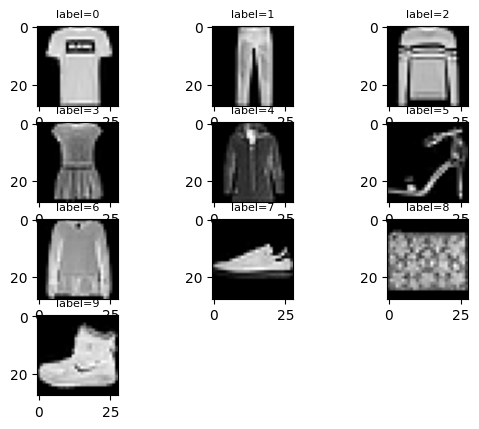

In [67]:
wandb.agent(sweep_id, train_wandb, count=50)